In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random

Caricamento file pickle

In [2]:
# Caricamento di models_atmos e models_zonmean
with open('models_atmos.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)
#with open('models_zonmean.pkl','rb') as file:
#    models_zonmean = dill.load(file)
#    era_seas_mean = dill.load(file)
with open('modelli_atmos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0 = pickle.load(f)
    list_cluster1 = pickle.load(f)
    list_cluster2 = pickle.load(f)
    list_cluster3 = pickle.load(f)
    list_cluster4 = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    atmos_cluster0 = pickle.load(f)
    atmos_cluster1 = pickle.load(f)
    atmos_cluster2 = pickle.load(f)
    atmos_cluster3 = pickle.load(f)
    atmos_cluster4 = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    atmos_cluster0_mean = pickle.load(f)
    atmos_cluster1_mean = pickle.load(f)
    atmos_cluster2_mean = pickle.load(f)
    atmos_cluster3_mean = pickle.load(f)
    atmos_cluster4_mean = pickle.load(f)

    #Caricamento dei cluster standard deviation in formato pdf
    atmos_cluster0_std = pickle.load(f)
    atmos_cluster1_std = pickle.load(f)
    atmos_cluster2_std = pickle.load(f)
    atmos_cluster3_std = pickle.load(f)
    atmos_cluster4_std = pickle.load(f)

In [3]:
# Caricamento di models_atmos e models_zonmean
with open('models_ua.pkl','rb') as file:
    models_ua = dill.load(file)
    era_ua_seas_mean= dill.load(file)
with open('models_ta.pkl','rb') as file:
    models_ta = dill.load(file)
    dataset_ERA_ta = dill.load(file)
    era_ta_seas_mean = dill.load(file)
    dict_egr_era = dill.load(file) #dizionario di ERA5_ta per il calcolo di egr

Bootstrap EGR 850hPa

In [4]:
for name in models_ta.keys():
    models_ta[name]['EGR seasonal mean DJF'] = models_ta[name]['EGR seasonal mean DJF'].sel(lat=slice(20,80)) * 86400 # così unità di misura è 1/day

In [5]:
def bs_sample_mean_egr(n_iterations,name_dict,name_list): 
    #creazione di una lista con il nome dei modelli
    list_name_models_egr= list(name_dict.keys())
    sample_rand = [] #inizializzazione lista di modelli presi in modo random, in numero n_iterations
    sample_mean = [] #inizializzazione di una lista in cui vado ad inserire la media di ogni sample, preso con l'estrazione random
    for n in range(n_iterations): #itero n_iterations volte
        sample_rand = random.sample(range(len(name_dict)), len(name_list)) #lista = estraggo 4 numeri random da 0 a 36, che sono il numero associato ad ogni modello
        sample_sum = 0 #inizializzazione ad ogni iterazione di sample_sum
        for i in range(len(name_list)): #ciclo sui 4 modelli presi
            sample_sum += name_dict[list_name_models_egr[sample_rand[i]]]['EGR seasonal mean DJF'][1] #850hPa
        sample_mean.append(sample_sum/len(sample_rand)) #calcolo il valore medio per ogni cluster
    return sample_mean

In [6]:
#funzione che calcola l'array mean-std-2.5th-97.5th della distribuzione bootstrap per ogni grid cell
def bs_compute_array_mean_std_95cl_egr(n_iterations,sample_mean): #95% confidence level
    #Inizializzazione array
    cell_grid_iteration = np.zeros(n_iterations) #array in cui metto i valori medi di un solo punto griglia per iterazioni diverse
    array_mean = np.zeros((len(sample_mean[0].lat),len(sample_mean[0].lon))) #array che racchiude i valori medi delle distribuzioni per ogni punto griglia
    array_std = np.zeros((len(sample_mean[0].lat),len(sample_mean[0].lon))) #array che racchiude le deviazioni standard delle distribuzioni per ogni punto griglia
    array_2th_percentile = np.zeros((len(sample_mean[0].lat),len(sample_mean[0].lon))) #array che racchiude i valori in cui si ha il 2.5th percentile delle distribuzioni per ogni pt griglia
    array_97th_percentile = np.zeros((len(sample_mean[0].lat),len(sample_mean[0].lon))) #array che racchiude i valori in cui si ha il 97.5th percentile delle distribuzioni per ogni pt griglia
    #Determino mean, std, 2.5th-97.5th percentile delle distribuzioni per ogni pt griglia
    for i in range(len(sample_mean[0].lat)): #ciclo sulle latitudini
        for j in range(len(sample_mean[0].lon)): #ciclo sulle longitudini
            for n in range(n_iterations): #ciclo sulle iterazioni
                cell_grid_iteration[n] = sample_mean[n][i][j] #n-esima iterazione, plev fissato, i-esimo elemento lat, primo elemento lon
            #Fuori dalle iterazioni perché ragiono sulla distribuzione, ottenuta dopo tutte le iterazioni
            # media e la deviazione standard
            array_mean[i,j] = np.mean(cell_grid_iteration)
            array_std[i,j] = np.std(cell_grid_iteration, ddof=1)  # Specifica ddof=1 per calcolare la deviazione standard campionaria (ddof = 1 --> divisione per N-1)
            # quinto e il 95-esimo percentile
            array_2th_percentile[i,j] = np.percentile(cell_grid_iteration, 2.5)
            array_97th_percentile[i,j] = np.percentile(cell_grid_iteration, 97.5)
    return array_mean,array_std,array_2th_percentile,array_97th_percentile

In [7]:
def plot_mean_cluster_egr(name_models_to_plot, name_dict, title_plot,title_pdf, v_min, v_max, fig_size):
    sum_bias = 0
    for i in range(len(name_models_to_plot)):
        model_name = name_models_to_plot[i]
        sum_bias = sum_bias + name_dict[model_name]['EGR seasonal mean DJF'][1] #850hPa
    mean_bias = sum_bias / len(name_models_to_plot)
    
    fig, ax = plt.subplots(figsize=fig_size, subplot_kw={"projection": ccrs.PlateCarree()})
    plot_mod = ax.pcolormesh(mean_bias.lon, mean_bias.lat, mean_bias, vmin=v_min, vmax=v_max, cmap='Reds')
    contour_models_mean = ax.contour(mean_bias.lon, mean_bias.lat, mean_bias, colors='g')
    ax.clabel(contour_models_mean, fmt='%1.1f')
    ax.coastlines()
    #valori assi            
    ax.set_xticks(np.arange(mean_bias[0].lon.min(),mean_bias[0].lon.max(), 20))
    ax.set_yticks(np.arange(mean_bias[0].lat.min(),mean_bias[0].lat.max(), 10))
    ax.set_ylabel('latitude')
    ax.set_xlabel('longitude')
    # Creazione di un oggetto Line2D per la legenda
    green_line = Line2D([0], [0], color='g', lw=2, label='multi model mean')    
    # Aggiungo la legenda al plot
    fig.legend(handles=[green_line], loc='upper right', bbox_to_anchor=(1.2, 1))
    fig.colorbar(plot_mod)
    fig.suptitle(title_plot, fontsize=16, y=1.02)

    fig.savefig(title_pdf, format='pdf')

In [8]:
#Funzione che fa il plot di media, std, 2.5th e 97.5th percentile della distribuzione bootstrap
def plot_bs_95cl_mean_std_egr(name_list,name_dict,array_mean,array_std,array_2th_percentile,array_97th_percentile):

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,8), subplot_kw={"projection": ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Aggiungo spazi verticali tra le subplots

    #valori estremanti di lon-lat
    min_lon = name_dict[name_list[0]]['EGR seasonal mean DJF'].lon.min()
    max_lon = name_dict[name_list[0]]['EGR seasonal mean DJF'].lon.max()
    min_lat = name_dict[name_list[0]]['EGR seasonal mean DJF'].lat.min()
    max_lat = name_dict[name_list[0]]['EGR seasonal mean DJF'].lat.max()

    ax[0,0].imshow(array_2th_percentile[::-1], cmap='Reds', extent=[min_lon, max_lon, min_lat, max_lat], transform=ccrs.PlateCarree())
    ax[0,0].invert_yaxis()
    ax[0,0].set_title('2.5th percentile')
    fig.colorbar(ax[0,0].imshow(array_2th_percentile, cmap='Reds'), ax=ax[0,0])

    ax[0,1].imshow(array_97th_percentile[::-1], cmap='Reds', extent=[min_lon, max_lon, min_lat, max_lat], transform=ccrs.PlateCarree())
    ax[0,1].invert_yaxis()
    ax[0,1].set_title('97.5th percentile')
    fig.colorbar(ax[0,1].imshow(array_97th_percentile, cmap='Reds'), ax=ax[0,1])

    ax[1,0].imshow(array_mean[::-1], cmap='Reds', extent=[min_lon, max_lon, min_lat, max_lat], transform=ccrs.PlateCarree())
    ax[1,0].invert_yaxis()
    ax[1,0].set_title('Mean of bootstrap distribution')
    fig.colorbar(ax[1,0].imshow(array_mean, cmap='Reds'), ax=ax[1,0])

    ax[1,1].imshow(array_std[::-1], cmap='Reds', extent=[min_lon, max_lon, min_lat, max_lat], transform=ccrs.PlateCarree())
    ax[1,1].invert_yaxis()
    ax[1,1].set_title('Std of bootstrap distribution')
    fig.colorbar(ax[1,1].imshow(array_std, cmap='Reds'), ax=ax[1,1])

    for i in range(2):
        for j in range(2):
            ax[i,j].set_xlabel('lon')
            ax[i,j].set_ylabel('lat')
            ax[i,j].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
            ax[i,j].coastlines()        
            ax[i,j].set_xticks(np.arange(min_lon,max_lon, 20))
            ax[i,j].set_yticks(np.arange(min_lat,max_lat, 10))
    fig.suptitle('Bootstrap distribution with 4 models')
    fig.show()

In [9]:
def bs_compute_matrix10_egr(name_list,name_dict,array_2th_percentile,array_97th_percentile): #funzione che calcola la matrice di 1 e 0 di dimensioni (30,78), che ha 1 dove l'elemento ij-esimo della matrice mean_bias è <=5th percentile oppure >=95th percentile e 0 altrimenti
    #Inizializzo sum_bias per il calcolo della media
    sum_bias = 0
    #calcolo il valor medio
    for i in range(len(name_list)):
        model_name = name_list[i]
        sum_bias = sum_bias + name_dict[model_name]['EGR seasonal mean DJF'][1] #850hPa
    #valor medio
    mean_bias = sum_bias / len(name_list)
    #mean_bias[0], array_2.5th_percentile, array_97.5th_percentile --> matrici (30,78)
    #Se l'elemento ij-esimo di mean_bias è <=2.5th percentile oppure >=97.5th percentile allora elemento ij-esimo è statisticamente differente --> metto un 1 nella matrice che creo
    #Creo la matrice che ha 1 nei pti statisticamente differenti e 0 nei pti che non lo sono
    matrix10 = np.zeros((len(mean_bias.lat.values),len(mean_bias.lon.values))) #inizializzo la matrice di 1 e 0, di dimensioni (30,78)
    for i in range(len(mean_bias.lat.values)): #ciclo sulle latitudini
        for j in range(len(mean_bias.lon.values)): #ciclo sulle longitudini
            if mean_bias[i][j] <= array_2th_percentile[i,j] or mean_bias[i][j] >= array_97th_percentile[i,j]: #<=2.5th oppure >=97.5th percentile --> statisticamente differenti
                matrix10[i,j] = 1
            else:
                matrix10[i,j] = 0 #superfluo
    return matrix10

In [10]:
#funzione per il plot del cluster medio + i puntini di significatività
def plot_bs_mean_cluster_matrix10_egr(name_list,name_dict,fig_size,v_min,v_max,matrix10,title_plot):#funzione che plotta il cluster medio + i pti significativamente differenti dalla distribuzione bootstrap
    #Inizializzo sum_bias per il calcolo della media
    sum_bias = 0
    #calcolo il valor medio
    for i in range(len(name_list)):
        model_name = name_list[i]
        sum_bias = sum_bias + name_dict[model_name]['EGR seasonal mean DJF'][1] #850hPa
    #valor medio
    mean_bias = sum_bias / len(name_list)
    fig, ax = plt.subplots(figsize=fig_size, subplot_kw={"projection": ccrs.PlateCarree()})
    #plot
    plot_mod = ax.pcolormesh(mean_bias.lon, mean_bias.lat, mean_bias, vmin=v_min, vmax=v_max, cmap='Reds')
    coords = np.where(matrix10 == 1) #array di valori di longitudini e latitudini in cui matrix10 = 1
    # Plot dei punti solo dove matrix10 è uguale a 1
    ax.plot(mean_bias.lon[coords[1]], mean_bias.lat[coords[0]], marker='o', color='black', markersize=2, linestyle='None', transform=ccrs.PlateCarree())
    #imposto lat-lon sugli assi
    ax.set_xticks(np.arange(mean_bias.lon.min(), mean_bias.lon.max(), 20))
    ax.set_yticks(np.arange(mean_bias.lat.min(), mean_bias.lat.max(), 10))
    #aggiungo coste
    ax.coastlines()
    #Label assi
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    #barra di colori
    fig.colorbar(plot_mod,ax=ax)
    # Titolo
    fig.suptitle(title_plot, fontsize=16, y=1.02)
    fig.show()

Cluster 0 (4 modelli)

In [11]:
#Estrazione in modo random di 4 modelli per 1000 iterazioni
sample_mean_cluster0 = bs_sample_mean_egr(1000,models_ta,list_cluster0)

In [12]:
#Calcolo di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
array_mean_cluster0,array_std_cluster0,array_2th_cluster0,array_97th_cluster0 = bs_compute_array_mean_std_95cl_egr(1000,sample_mean_cluster0)

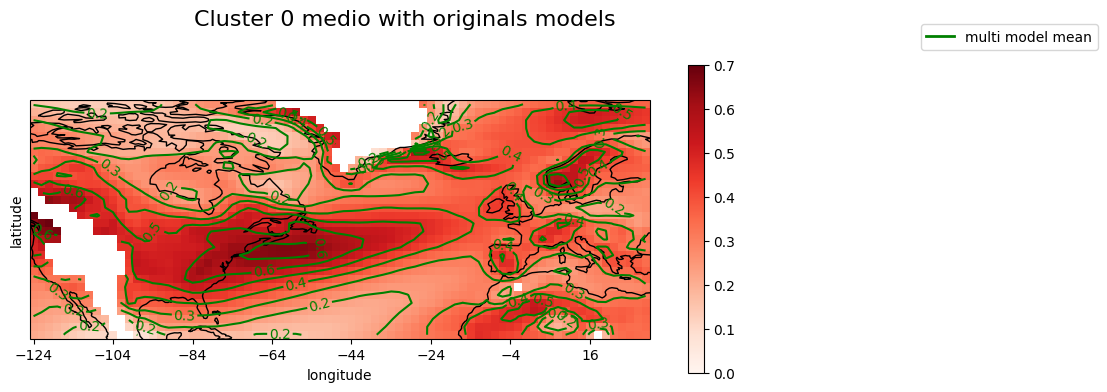

In [13]:
#Plot cluster medio
plot_mean_cluster_egr(list_cluster0,models_ta,'Cluster 0 medio with originals models','cl0_mean_egr.pdf',0,0.7,(10,4))

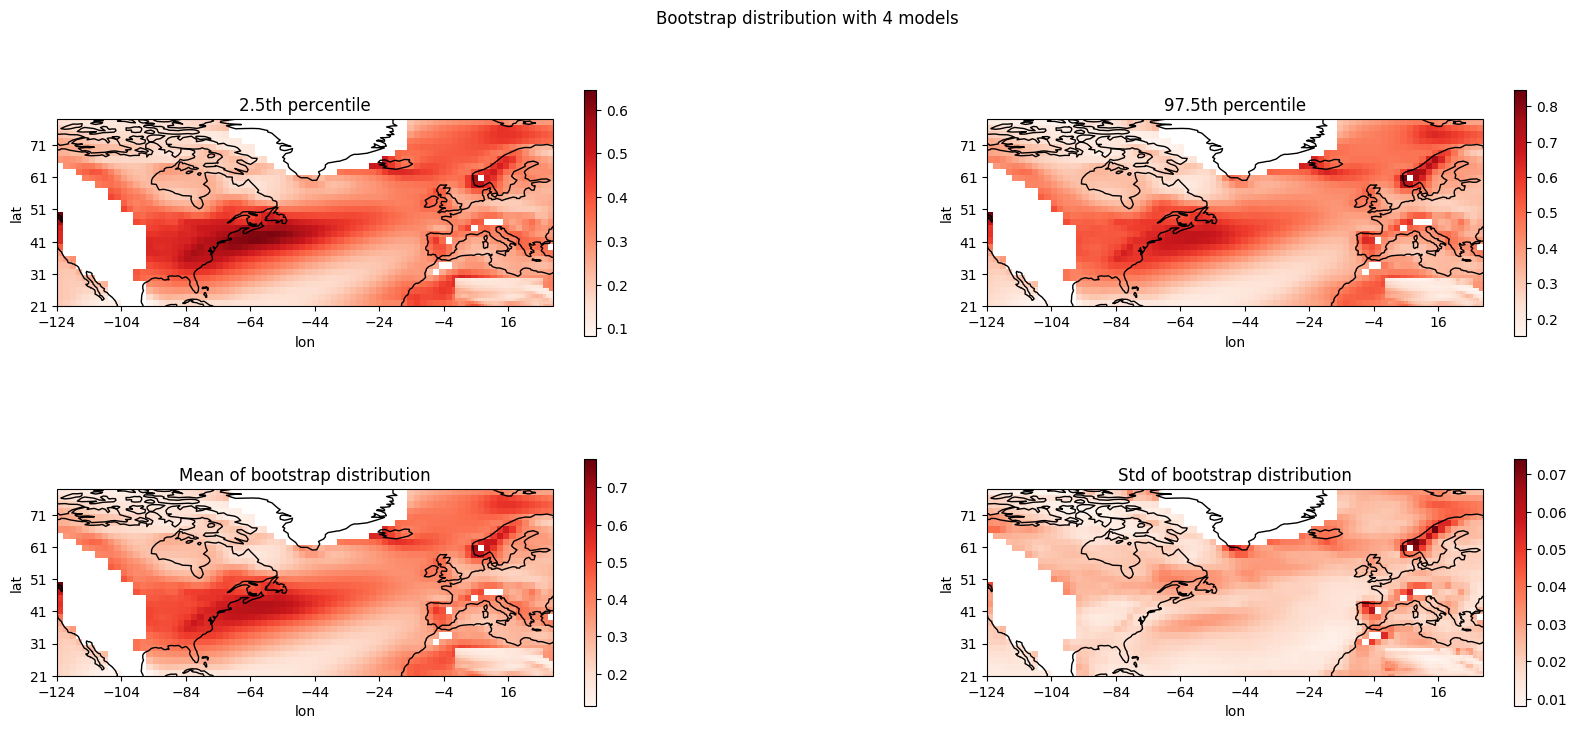

In [14]:
#plot di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
plot_bs_95cl_mean_std_egr(list_cluster0,models_ta,array_mean_cluster0,array_std_cluster0,array_2th_cluster0,array_97th_cluster0)

In [15]:
#Determinazione della matrice di 1,0. 1 si ha quando l'elemento ij-esimo è <= 5th oppure >= 95th percentile --> significativamente differenti
matrix10_cluster0 = bs_compute_matrix10_egr(list_cluster0,models_ta,array_2th_cluster0,array_97th_cluster0)

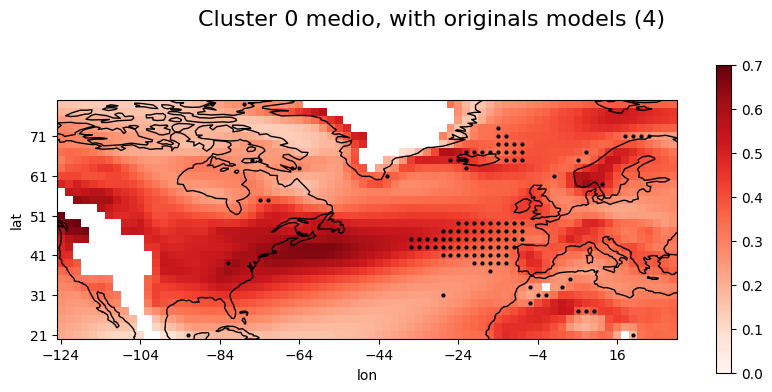

In [16]:
#plot del cluster medio con puntini di significatività
plot_bs_mean_cluster_matrix10_egr(list_cluster0,models_ta,(10,4),0,0.7,matrix10_cluster0,'Cluster 0 medio, with originals models (4)')

In [17]:
print(matrix10_cluster0.shape)

a  = 30 * 78
print(a)
number = 0
for i in range(30):
    for j in range(78):
        if matrix10_cluster0[i,j] == 1:
            number = number + 1
print(number)

(30, 78)
2340
116


Cluster 1 (7 modelli)

In [18]:
#Estrazione in modo random di 4 modelli per 1000 iterazioni
sample_mean_cluster1 = bs_sample_mean_egr(1000,models_ta,list_cluster1)

In [19]:
#Calcolo di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
array_mean_cluster1,array_std_cluster1,array_2th_cluster1,array_97th_cluster1 = bs_compute_array_mean_std_95cl_egr(1000,sample_mean_cluster1)

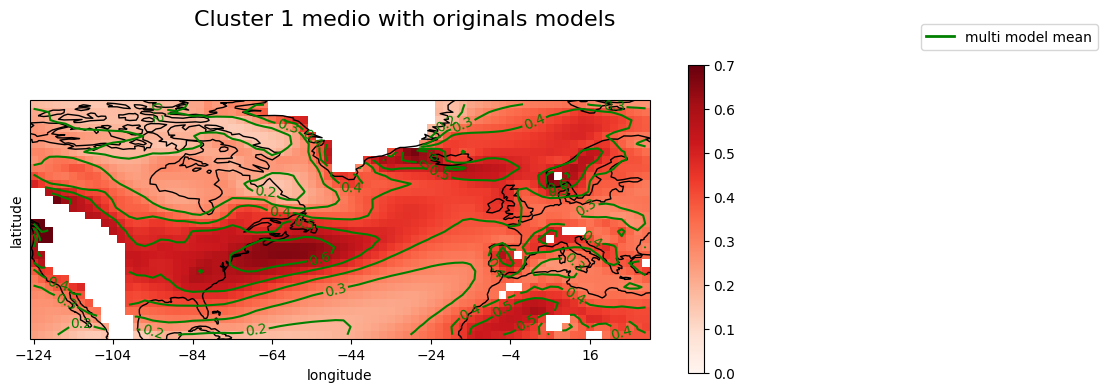

In [20]:
#Plot cluster medio
plot_mean_cluster_egr(list_cluster1,models_ta,'Cluster 1 medio with originals models','cl1_mean_egr.pdf',0,0.7,(10,4))

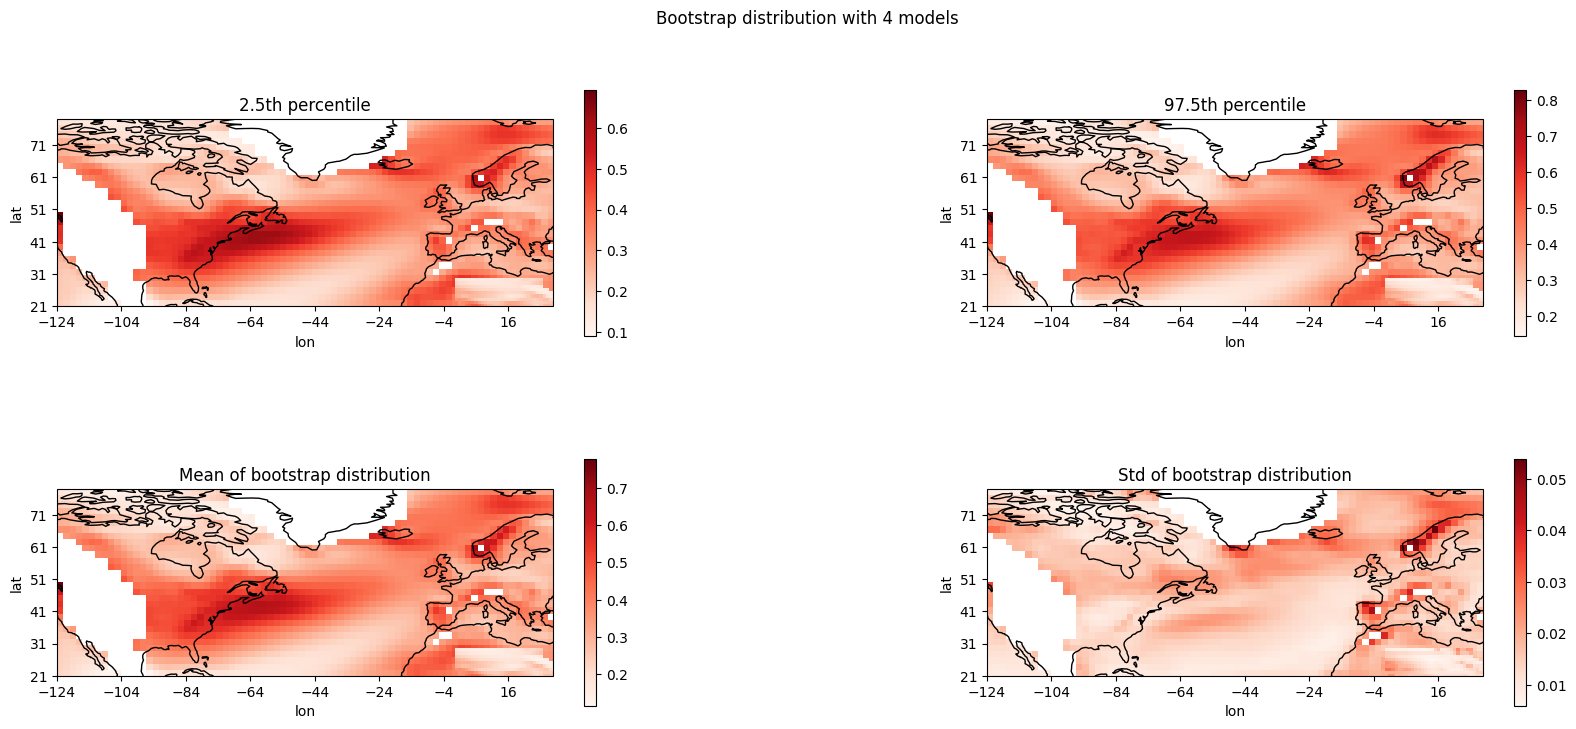

In [21]:
#plot di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
plot_bs_95cl_mean_std_egr(list_cluster1,models_ta,array_mean_cluster1,array_std_cluster1,array_2th_cluster1,array_97th_cluster1)

In [22]:
#Determinazione della matrice di 1,0. 1 si ha quando l'elemento ij-esimo è <= 5th oppure >= 95th percentile --> significativamente differenti
matrix10_cluster1 = bs_compute_matrix10_egr(list_cluster1,models_ta,array_2th_cluster1,array_97th_cluster1)

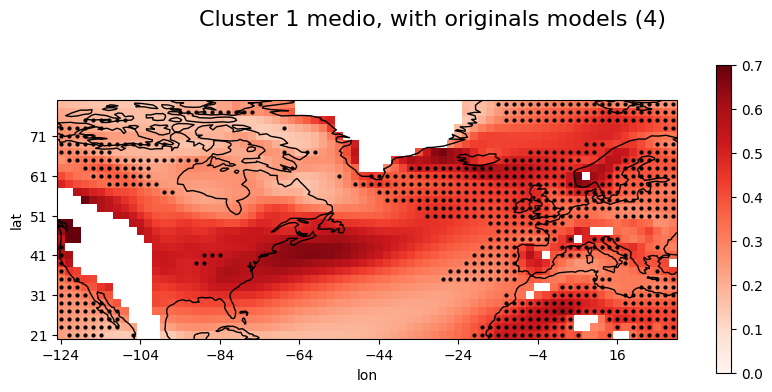

In [23]:
#plot del cluster medio con puntini di significatività
plot_bs_mean_cluster_matrix10_egr(list_cluster1,models_ta,(10,4),0,0.7,matrix10_cluster1,'Cluster 1 medio, with originals models (4)')

In [24]:
print(matrix10_cluster1.shape)

a  = 30 * 78
print(a)
number = 0
for i in range(30):
    for j in range(78):
        if matrix10_cluster1[i,j] == 1:
            number = number + 1
print(number)

(30, 78)
2340
705


Cluster 2 (11 modelli)

In [25]:
#Estrazione in modo random di 4 modelli per 1000 iterazioni
sample_mean_cluster2 = bs_sample_mean_egr(1000,models_ta,list_cluster2)

In [26]:
#Calcolo di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
array_mean_cluster2,array_std_cluster2,array_2th_cluster2,array_97th_cluster2 = bs_compute_array_mean_std_95cl_egr(1000,sample_mean_cluster2)

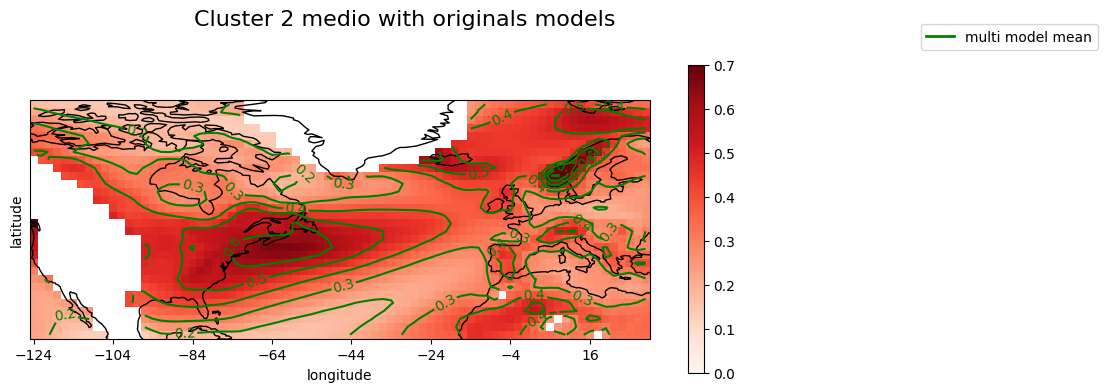

In [27]:
#Plot cluster medio
plot_mean_cluster_egr(list_cluster2,models_ta,'Cluster 2 medio with originals models','cl2_mean_egr.pdf',0,0.7,(10,4))

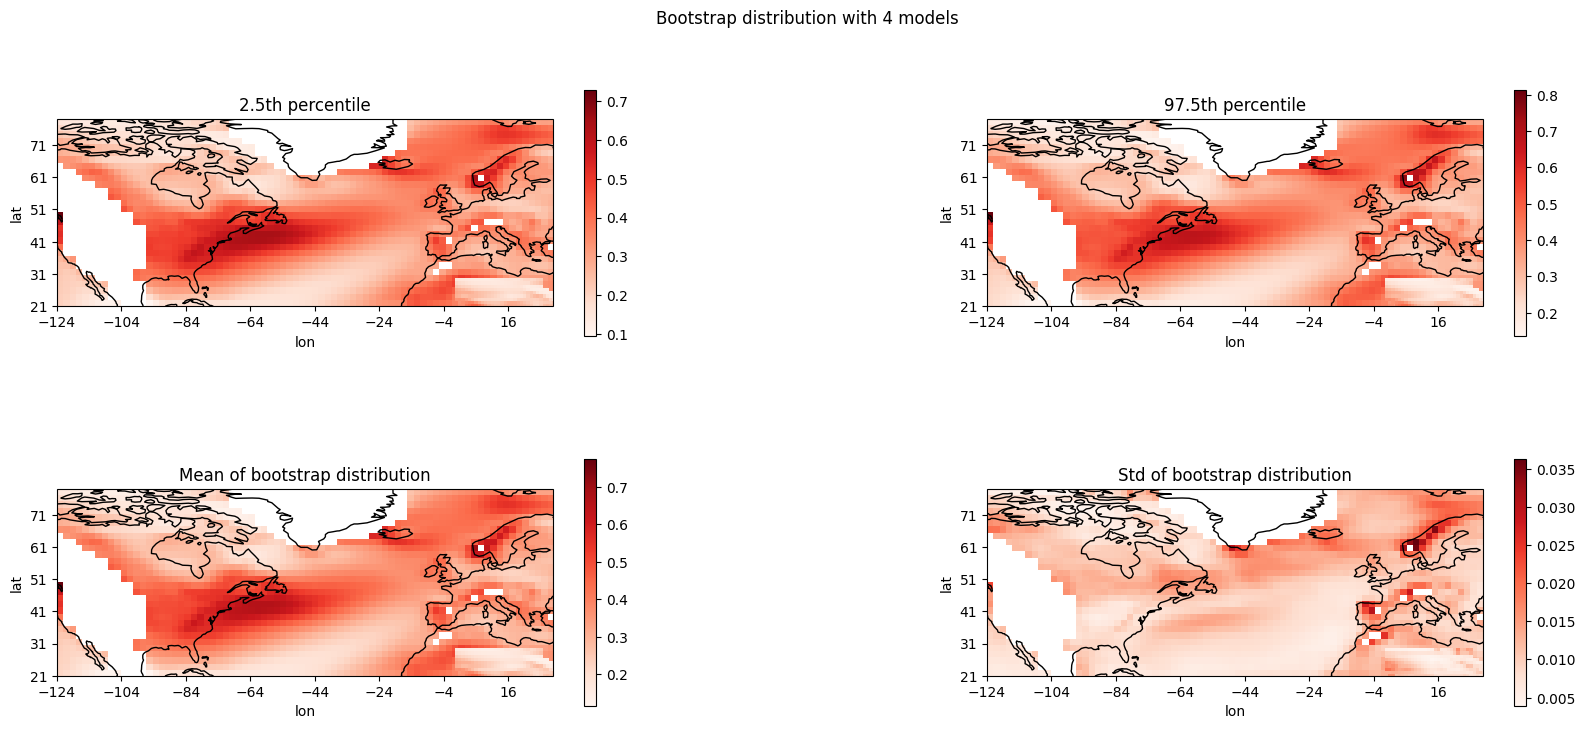

In [28]:
#plot di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
plot_bs_95cl_mean_std_egr(list_cluster2,models_ta,array_mean_cluster2,array_std_cluster2,array_2th_cluster2,array_97th_cluster2)

In [29]:
#Determinazione della matrice di 1,0. 1 si ha quando l'elemento ij-esimo è <= 5th oppure >= 95th percentile --> significativamente differenti
matrix10_cluster2 = bs_compute_matrix10_egr(list_cluster2,models_ta,array_2th_cluster2,array_97th_cluster2)

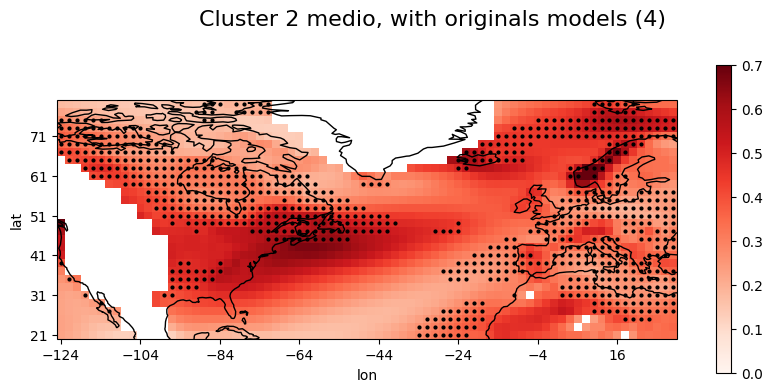

In [30]:
#plot del cluster medio con puntini di significatività
plot_bs_mean_cluster_matrix10_egr(list_cluster2,models_ta,(10,4),0,0.7,matrix10_cluster2,'Cluster 2 medio, with originals models (4)')

In [31]:
print(matrix10_cluster2.shape)

a  = 30 * 78
print(a)
number = 0
for i in range(30):
    for j in range(78):
        if matrix10_cluster2[i,j] == 1:
            number = number + 1
print(number)

(30, 78)
2340
778


Cluster 3 (13 modelli)

In [32]:
#Estrazione in modo random di 4 modelli per 1000 iterazioni
sample_mean_cluster3 = bs_sample_mean_egr(1000,models_ta,list_cluster3)

In [33]:
#Calcolo di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
array_mean_cluster3,array_std_cluster3,array_2th_cluster3,array_97th_cluster3 = bs_compute_array_mean_std_95cl_egr(1000,sample_mean_cluster3)

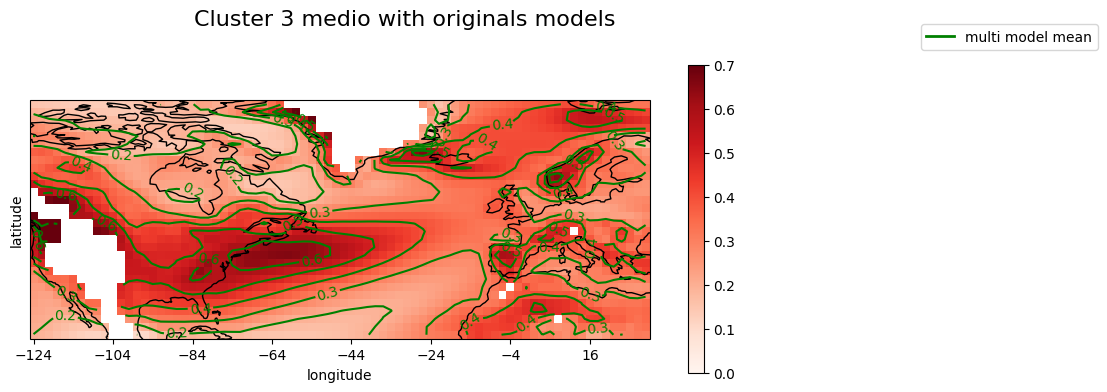

In [34]:
#Plot cluster medio
plot_mean_cluster_egr(list_cluster3,models_ta,'Cluster 3 medio with originals models','cl3_mean_egr.pdf',0,0.7,(10,4))

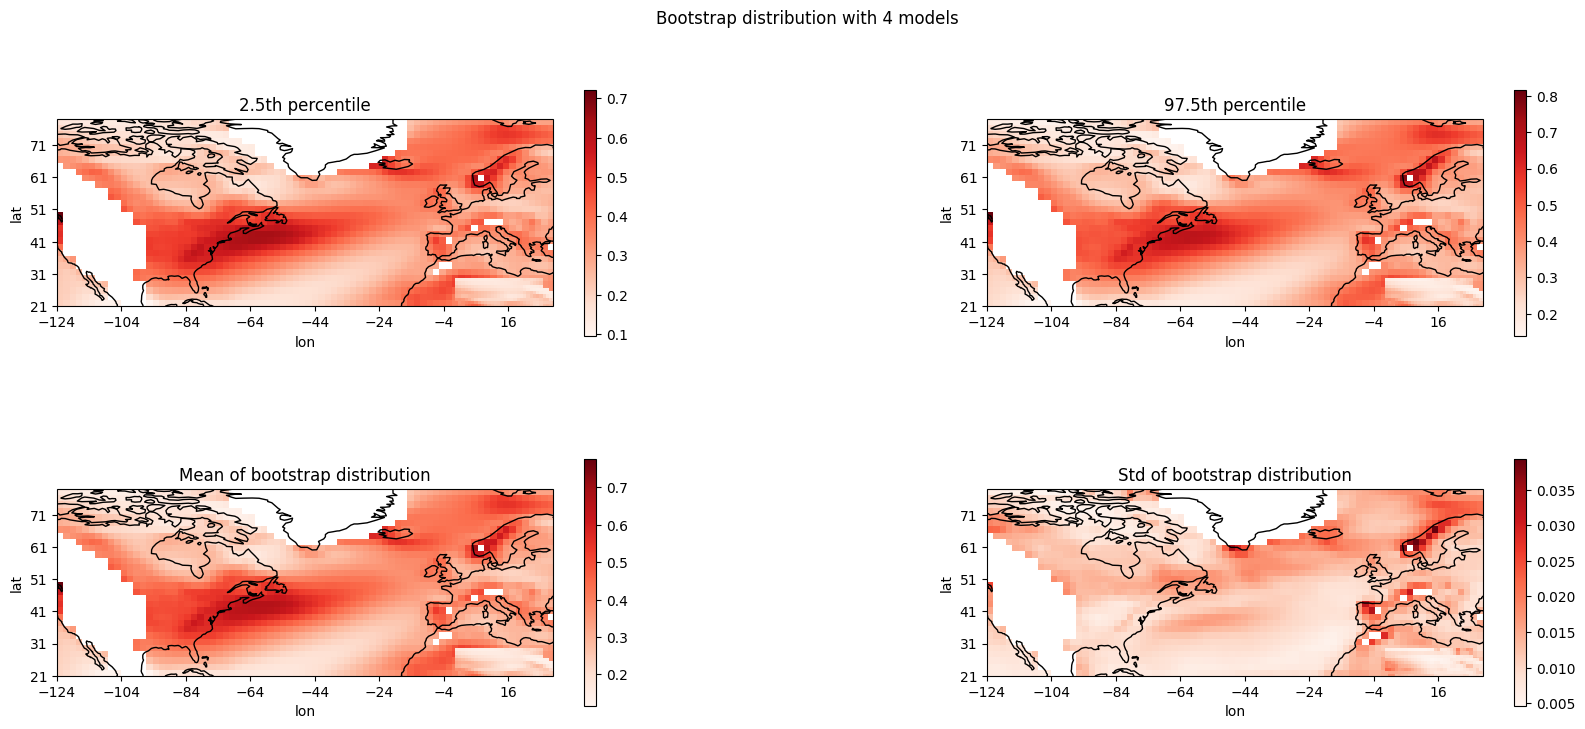

In [35]:
#plot di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
plot_bs_95cl_mean_std_egr(list_cluster3,models_ta,array_mean_cluster3,array_std_cluster3,array_2th_cluster3,array_97th_cluster3)

In [36]:
#Determinazione della matrice di 1,0. 1 si ha quando l'elemento ij-esimo è <= 5th oppure >= 95th percentile --> significativamente differenti
matrix10_cluster3 = bs_compute_matrix10_egr(list_cluster3,models_ta,array_2th_cluster3,array_97th_cluster3)

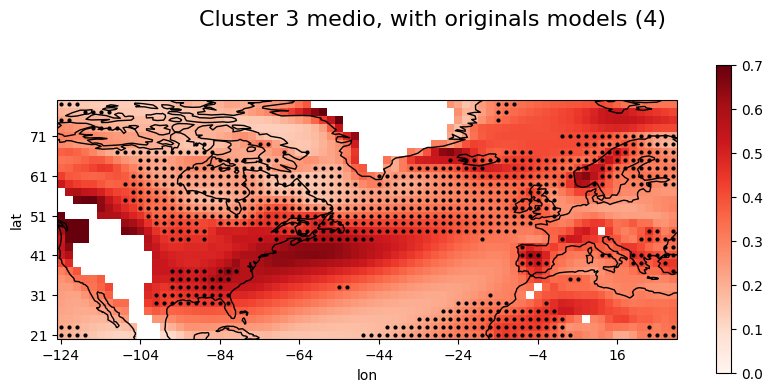

In [37]:
#plot del cluster medio con puntini di significatività
plot_bs_mean_cluster_matrix10_egr(list_cluster3,models_ta,(10,4),0,0.7,matrix10_cluster3,'Cluster 3 medio, with originals models (4)')

In [38]:
print(matrix10_cluster3.shape)

a  = 30 * 78
print(a)
number = 0
for i in range(30):
    for j in range(78):
        if matrix10_cluster3[i,j] == 1:
            number = number + 1
print(number)

(30, 78)
2340
791


Cluster 4 (2 modelli)

In [39]:
#Estrazione in modo random di 4 modelli per 1000 iterazioni
sample_mean_cluster4 = bs_sample_mean_egr(1000,models_ta,list_cluster4)

In [40]:
#Calcolo di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
array_mean_cluster4,array_std_cluster4,array_2th_cluster4,array_97th_cluster4 = bs_compute_array_mean_std_95cl_egr(1000,sample_mean_cluster4)

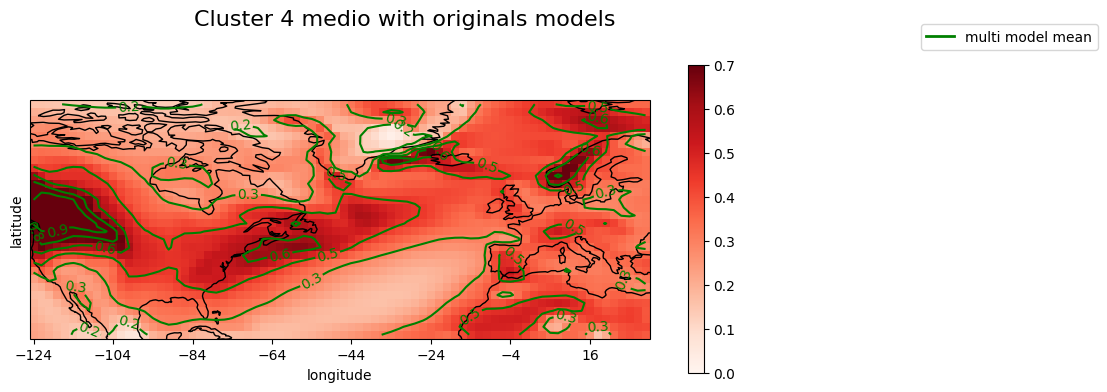

In [41]:
#Plot cluster medio
plot_mean_cluster_egr(list_cluster4,models_ta,'Cluster 4 medio with originals models','cl4_mean_egr.pdf',0,0.7,(10,4))

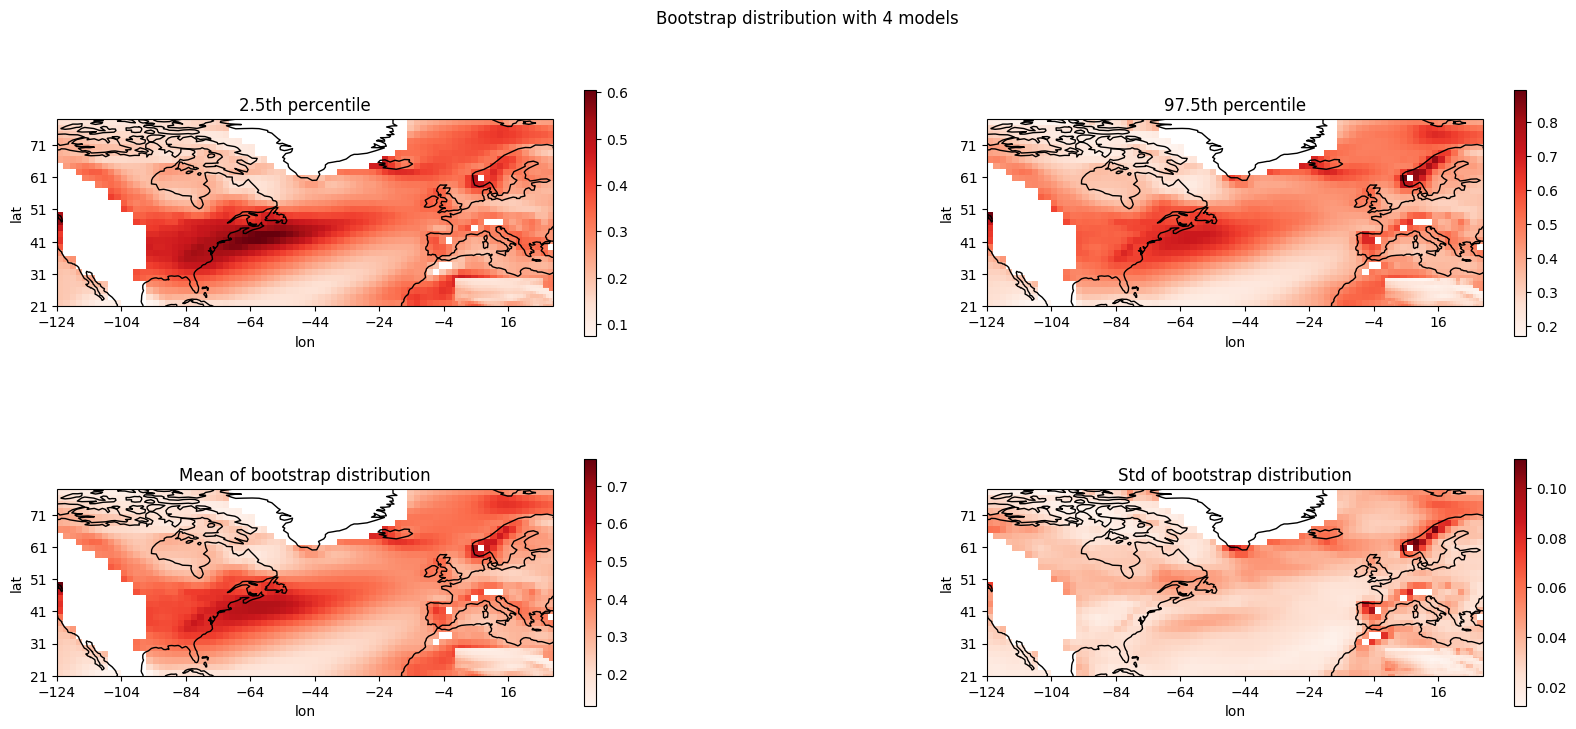

In [42]:
#plot di array_mean, array_std, array_2th_percentile, array_97th_percentile della distribuzione bootstrap
plot_bs_95cl_mean_std_egr(list_cluster4,models_ta,array_mean_cluster4,array_std_cluster4,array_2th_cluster4,array_97th_cluster4)

In [43]:
#Determinazione della matrice di 1,0. 1 si ha quando l'elemento ij-esimo è <= 5th oppure >= 95th percentile --> significativamente differenti
matrix10_cluster4 = bs_compute_matrix10_egr(list_cluster4,models_ta,array_2th_cluster4,array_97th_cluster4)

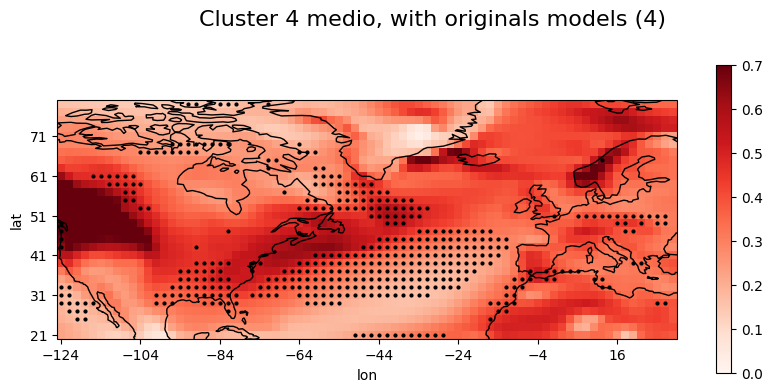

In [44]:
#plot del cluster medio con puntini di significatività
plot_bs_mean_cluster_matrix10_egr(list_cluster4,models_ta,(10,4),0,0.7,matrix10_cluster4,'Cluster 4 medio, with originals models (4)')

In [45]:
print(matrix10_cluster4.shape)

a  = 30 * 78
print(a)
number = 0
for i in range(30):
    for j in range(78):
        if matrix10_cluster4[i,j] == 1:
            number = number + 1
print(number)

(30, 78)
2340
438


Salvataggio in file pickle

In [46]:
# Salvataggio in un file Pickle
with open('bootstrap_egr.pickle', 'wb') as f: #'wb' = write binary
    pickle.dump(array_2th_cluster0, f) #salvataggio array cluster 0
    pickle.dump(array_97th_cluster0, f)
    pickle.dump(array_mean_cluster0, f)
    pickle.dump(array_std_cluster0, f)
    pickle.dump(matrix10_cluster0, f)

    pickle.dump(array_2th_cluster1, f) #salvataggio array cluster 1
    pickle.dump(array_97th_cluster1, f)
    pickle.dump(array_mean_cluster1, f)
    pickle.dump(array_std_cluster1, f)
    pickle.dump(matrix10_cluster1, f)

    pickle.dump(array_2th_cluster2, f) #salvataggio array cluster 2
    pickle.dump(array_97th_cluster2, f)
    pickle.dump(array_mean_cluster2, f)
    pickle.dump(array_std_cluster2, f)
    pickle.dump(matrix10_cluster2, f)

    pickle.dump(array_2th_cluster3, f) #salvataggio array cluster 3
    pickle.dump(array_97th_cluster3, f)
    pickle.dump(array_mean_cluster3, f)
    pickle.dump(array_std_cluster3, f)
    pickle.dump(matrix10_cluster3, f)

    pickle.dump(array_2th_cluster4, f) #salvataggio array cluster 4
    pickle.dump(array_97th_cluster4, f)
    pickle.dump(array_mean_cluster4, f)
    pickle.dump(array_std_cluster4, f)
    pickle.dump(matrix10_cluster4, f)